In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  
from torchvision.models import googlenet, GoogLeNet_Weights

In [2]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Should print: cuda


Using device: cpu


In [ ]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder(r'dataset\Training', transform=data_transforms)
test_dataset = ImageFolder(r'dataset\Testing', transform=data_transforms)


In [4]:
train_size = int(0.85 * len(train_dataset))  # 85% for training
val_size = len(train_dataset) - train_size   # 15% for validation
train_data, val_data = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [5]:
# Parameters
IMAGE_PER_CATEGORY = 4
CATEGORIES = train_dataset.classes
NUM_OF_CATEGORIES = len(CATEGORIES)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Prepare image samples per category
category_images = {cat: [] for cat in CATEGORIES}

In [6]:
for images, labels in train_loader:
    for img, label in zip(images, labels):
        cat = CATEGORIES[label]
        if len(category_images[cat]) < IMAGE_PER_CATEGORY:
            category_images[cat].append(img)
    if all(len(imgs) >= IMAGE_PER_CATEGORY for imgs in category_images.values()):
        break


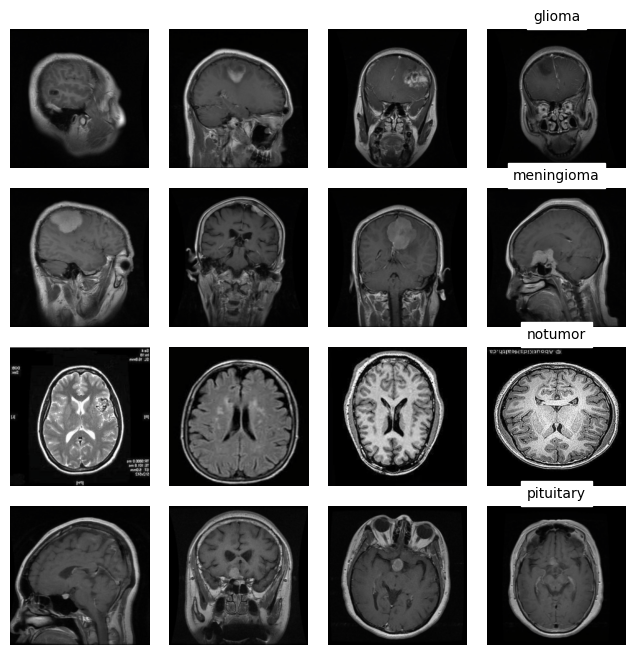

In [7]:
fig = plt.figure(figsize=(12, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(IMAGE_PER_CATEGORY, NUM_OF_CATEGORIES), axes_pad=0.2)

i = 0
for col, category in enumerate(CATEGORIES):
    for row in range(IMAGE_PER_CATEGORY):
        ax = grid[i]
        img_tensor = category_images[category][row]
        img = img_tensor.numpy().transpose((1, 2, 0))
        img = (img * std + mean).clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        if row == IMAGE_PER_CATEGORY - 1:
            ax.set_title(category, fontsize=10, backgroundcolor='white')
        i += 1

plt.show()

In [8]:
num_classes = len(train_dataset.classes)
model = models.googlenet(pretrained=True)

C:\Users\reach\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\reach\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Replace classifier
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # 🔽 Calculate batch accuracy
        batch_acc = 100 * predicted.eq(labels).sum().item() / labels.size(0)

        # 🔽 Update progress bar with loss and batch accuracy
        progress_bar.set_postfix(loss=loss.item(), batch_acc=f"{batch_acc:.2f}%")

    # 🔽 Final epoch-level training accuracy
    train_acc = 100 * correct / total

    # Validation after epoch
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            _, val_preds = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_preds.eq(val_labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")




Epoch 1: 100%|██████████| 304/304 [09:39<00:00,  1.91s/it, batch_acc=85.71%, loss=0.292]  


Epoch 1: Train Acc=88.55%, Val Acc=96.73%


Epoch 2: 100%|██████████| 304/304 [09:36<00:00,  1.90s/it, batch_acc=100.00%, loss=0.05]   


Epoch 2: Train Acc=97.22%, Val Acc=97.43%


Epoch 3: 100%|██████████| 304/304 [09:21<00:00,  1.85s/it, batch_acc=100.00%, loss=0.145]  


Epoch 3: Train Acc=98.68%, Val Acc=98.02%


Epoch 4: 100%|██████████| 304/304 [10:46<00:00,  2.13s/it, batch_acc=100.00%, loss=0.00553]


Epoch 4: Train Acc=99.32%, Val Acc=97.78%


Epoch 5: 100%|██████████| 304/304 [13:17<00:00,  2.62s/it, batch_acc=100.00%, loss=0.0368]  


Epoch 5: Train Acc=99.36%, Val Acc=98.25%


Epoch 6: 100%|██████████| 304/304 [13:42<00:00,  2.71s/it, batch_acc=100.00%, loss=0.00279] 


Epoch 6: Train Acc=99.42%, Val Acc=98.13%


Epoch 7: 100%|██████████| 304/304 [13:18<00:00,  2.63s/it, batch_acc=100.00%, loss=0.0105]  


Epoch 7: Train Acc=99.63%, Val Acc=98.48%


Epoch 8: 100%|██████████| 304/304 [13:15<00:00,  2.62s/it, batch_acc=100.00%, loss=0.00372] 


Epoch 8: Train Acc=99.28%, Val Acc=98.60%


Epoch 9: 100%|██████████| 304/304 [09:43<00:00,  1.92s/it, batch_acc=71.43%, loss=1.08]     


Epoch 9: Train Acc=99.42%, Val Acc=97.20%


Epoch 10: 100%|██████████| 304/304 [08:42<00:00,  1.72s/it, batch_acc=100.00%, loss=0.00143] 


Epoch 10: Train Acc=99.63%, Val Acc=98.83%


In [12]:
# Final Test Accuracy
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_preds = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_preds.eq(test_labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"Final Test Accuracy:        {test_acc:.2f}%")

Final Test Accuracy:        99.16%
